## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


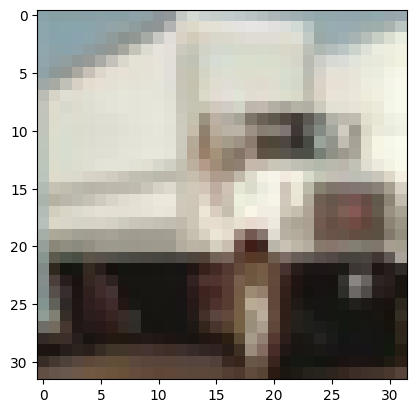

In [7]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [8]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [10]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [11]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                        

We still have 181K parameters, even though this is a "small" model.


In [12]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 15s 8ms/step - loss: 1.5995 - accuracy: 0.4252 - val_loss: 1.4720 - val_accuracy: 0.4833
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2745 - accuracy: 0.5482 - val_loss: 1.2077 - val_accuracy: 0.5680
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1440 - accuracy: 0.5984 - val_loss: 1.1286 - val_accuracy: 0.5985
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0467 - accuracy: 0.6360 - val_loss: 1.1827 - val_accuracy: 0.5864
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9710 - accuracy: 0.6598 - val_loss: 1.0561 - val_accuracy: 0.6298
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9028 - accuracy: 0.6856 - val_loss: 1.0119 - val_accuracy: 0.6483
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8417 - accuracy: 0.7070 - val_loss: 1.0067 - val_ac

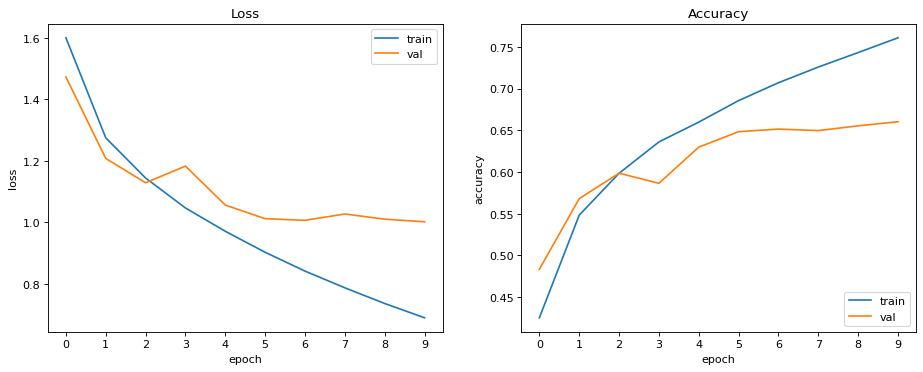

In [13]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [14]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.630731, Accuracy: 0.785760
 Test Loss: 1.001906, Accuracy: 0.660200

[[716  16  60  23  27  12   6  22  71  27]
 [ 27 774  19  22  11  13  15  10  54 104]
 [ 39   6 512  68  59  62  46  30   5   9]
 [  9   5  51 373  28 153  31  23  11  10]
 [ 22   4 111 102 625  62  30  74   5   8]
 [  9   2  51 142  30 487  15  33   2   3]
 [ 21  14  88 132  93  57 803  15   7  17]
 [ 12   4  58  64  95 103  12 745   6  17]
 [ 85  29  28  35  17  21  17   6 793  31]
 [ 60 146  22  39  15  30  25  42  46 774]]


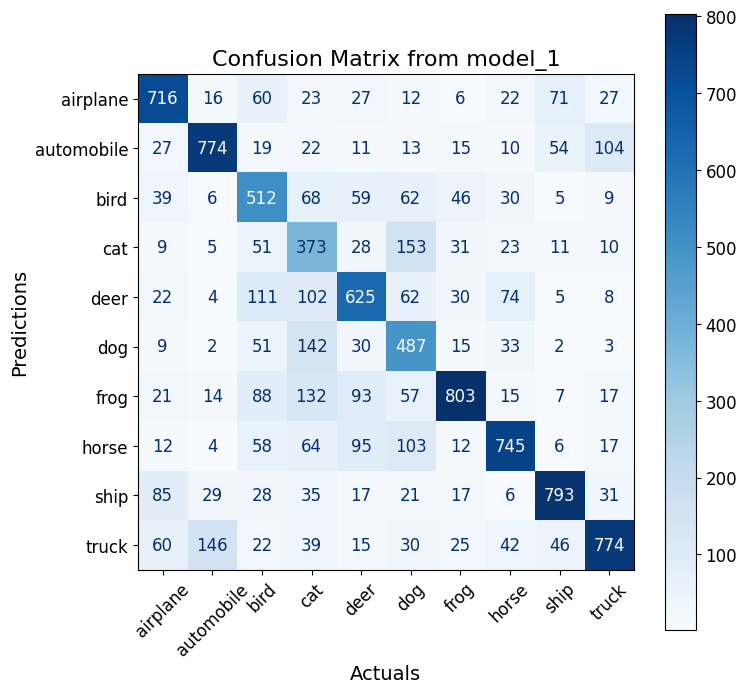

In [15]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [16]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.73      0.72      0.72      1000
  automobile       0.74      0.77      0.76      1000
        bird       0.61      0.51      0.56      1000
         cat       0.54      0.37      0.44      1000
        deer       0.60      0.62      0.61      1000
         dog       0.63      0.49      0.55      1000
        frog       0.64      0.80      0.71      1000
       horse       0.67      0.74      0.70      1000
        ship       0.75      0.79      0.77      1000
       truck       0.65      0.77      0.70      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

In [17]:
# Let's build a CNN using Keras' Sequential capabilities
model_2 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

model_2.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                  

In [18]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 14s 8ms/step - loss: 1.5961 - accuracy: 0.4184 - val_loss: 1.5311 - val_accuracy: 0.4556
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2045 - accuracy: 0.5715 - val_loss: 1.0806 - val_accuracy: 0.6169
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0219 - accuracy: 0.6394 - val_loss: 1.1503 - val_accuracy: 0.5946
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9022 - accuracy: 0.6830 - val_loss: 1.0386 - val_accuracy: 0.6355
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8236 - accuracy: 0.7127 - val_loss: 0.8729 - val_accuracy: 0.7019
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7583 - accuracy: 0.7354 - val_loss: 0.8512 - val_accuracy: 0.7081
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7049 - accuracy: 0.7551 - val_loss: 0.9821 - val_ac

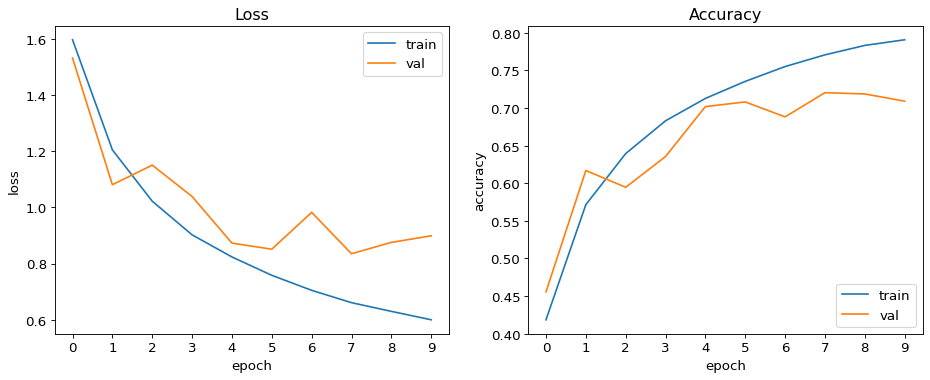

In [19]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['loss'])
ax.plot(history_2.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [20]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_2.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.571063, Accuracy: 0.797380
 Test Loss: 0.898824, Accuracy: 0.709100

[[875  51 140  58  36  25  11  46 152  67]
 [  9 812   6   5   3   3   2   1  25  72]
 [ 15   0 486  32  37  25  15  12   7   2]
 [  8   6  46 459  42 118  35  43   8   8]
 [ 14   3 105  81 719  68  26 113   6   5]
 [  7   9  87 212  41 656  18 100   5   5]
 [ 14  17  92 121  73  60 873  20   5  17]
 [  5   1  17  10  30  33   9 648   0   7]
 [ 30  28  13  13  11   3   7   2 770  24]
 [ 23  73   8   9   8   9   4  15  22 793]]


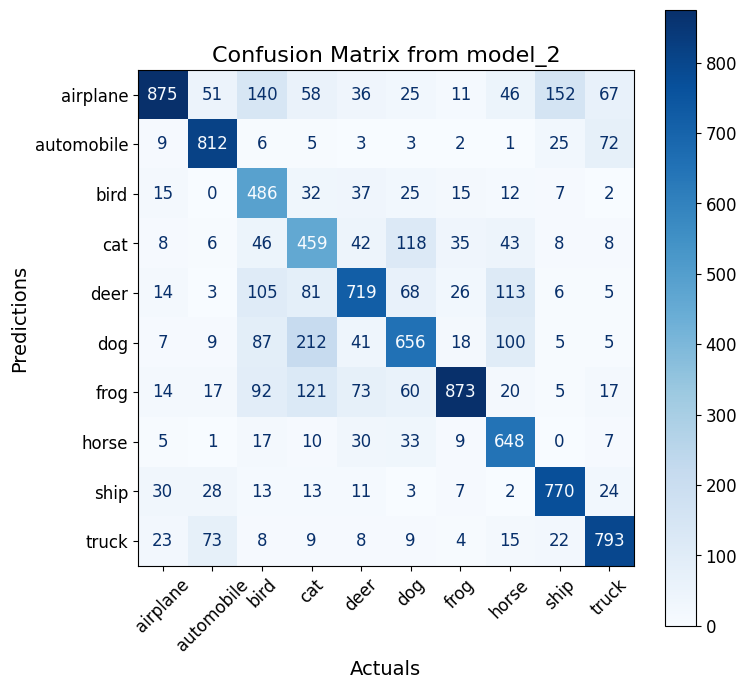

In [21]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_2', fontsize=16)
plt.show()

In [22]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.60      0.88      0.71      1000
  automobile       0.87      0.81      0.84      1000
        bird       0.77      0.49      0.60      1000
         cat       0.59      0.46      0.52      1000
        deer       0.63      0.72      0.67      1000
         dog       0.58      0.66      0.61      1000
        frog       0.68      0.87      0.76      1000
       horse       0.85      0.65      0.74      1000
        ship       0.85      0.77      0.81      1000
       truck       0.82      0.79      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



313/313 [==============================] - 1s 3ms/step


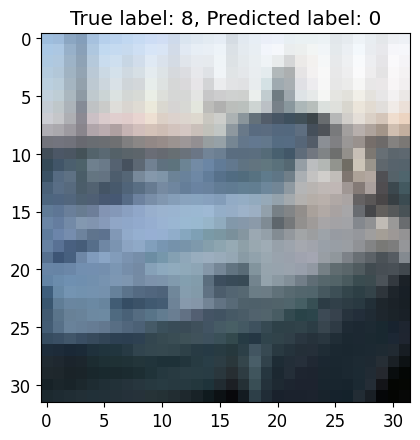

In [23]:
# Assuming you have a trained model, test dataset (x_test), and true labels (y_test)
# Get predictions from the model
predictions = model_2.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Find misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

if len(misclassified_indices) > 0:
    # Get the first misclassified image
    index = misclassified_indices[0]
    misclassified_image = x_test[index]
    true_label = true_classes[index]
    predicted_label = predicted_classes[index]

    # Display the misclassified image
    plt.imshow(misclassified_image)
    plt.title(f'True label: {true_label}, Predicted label: {predicted_label}')
    plt.show()
else:
    print("No misclassified images found.")